In [1]:
# note that this Jupyter notebook should be run twice to JIT compile it, if time measurements are needed
# variables with suffix '_n' denote that nudged data are being used

# dependencies
using MovingWeightedLeastSquares
using Plots
using Cubature
using Interpolations
using Base.Profile

# initialization of PGFPlots plotting backend
pgfplots();

In [2]:
# initialize the dataset in this Jupyter notebook cell

# from, to, step
from = -4;
to = 4;
step = 0.2;
# a random number in interval (-ng/2, ng/2) will be added to each x in xs
ng = 0.2;
# function to be approximated
f = x -> 2sin(x) * cos(x) + 10;
# weight function
w = (d, e) -> exp(-d^2);
# degree of used polynomial for approximation
deg = 2;
# eps of the weight function
eps = 0.4;
time_tries = 50;

In [3]:
rg = from:step:to
xs = collect(rg);
# uncomment this, if repeated evaluation with the same nudges is needed
xs_n = xs .+ ng * rand(size(xs)) - ng/2;
fs = [f(x) for x in xs];
fs_n = [f(x) for x in xs_n]

# creation of approximation objects
nv = mwlsNaive(xs, fs, eps, w, maxDegree = deg);
nv_n = mwlsNaive(xs_n, fs_n, eps, w, maxDegree = deg);
kd = mwlsKd(xs, fs, eps, w, maxDegree = deg);
kd_n = mwlsKd(xs_n, fs_n, eps, w, maxDegree = deg);
cll = mwlsCll(xs, fs, eps, w, maxDegree = deg);
cll_n = mwlsCll(xs_n, fs_n, eps, w, maxDegree = deg);

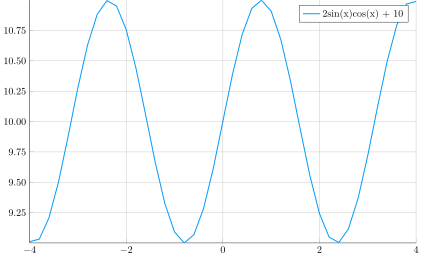

In [4]:
# graph of the original function
plot(xs, fs, label = "2sin(x)cos(x) + 10")

In [5]:
# function for better @time test
function mass_approx(obj::MwlsObject, xs::Array{T}) where {T <: Real}
    [obj(x) for x in xs]
end

mass_approx (generic function with 1 method)

In [6]:
function errfunc(obj::MwlsObject, reffunc::Function, b, e)
    hquadrature(x -> abs(obj(x) - reffunc(x))/(e - b), b, e, abstol = 1e-9)
end

errfunc (generic function with 1 method)

In [ ]:
# construction of approximation at each input vector
nvs = mass_approx(nv, xs);

In [ ]:
@time begin for i in 1:time_tries mass_approx(nv, xs) end end

In [ ]:
kds = mass_approx(kd, xs);

In [ ]:
@time begin for i in 1:time_tries mass_approx(kd, xs) end end

In [ ]:
clls = mass_approx(cll, xs);

In [ ]:
@time begin for i in 1:time_tries mass_approx(cll, xs) end end

In [ ]:
Profile.print()

In [ ]:
nvs_n = mass_approx(nv_n, xs_n);

In [ ]:
@time begin for i in 1:time_tries mass_approx(nv_n, xs_n) end end

In [ ]:
kds_n = mass_approx(kd_n, xs_n);

In [ ]:
@time begin for i in 1:time_tries mass_approx(kd_n, xs_n) end end

In [ ]:
clls_n = mass_approx(cll_n, xs_n);

In [ ]:
@time begin for i in 1:time_tries mass_approx(cll_n, xs_n) end end

In [ ]:
# absolute errors of approximations
nverr = abs.(nvs .- fs);
kderr = abs.(kds .- fs);
cllerr = abs.(clls .- fs);
nverr_n = abs.(nvs_n .- fs_n);
kderr_n = abs.(kds_n .- fs_n);
cllerr_n = abs.(clls_n .- fs_n);

In [ ]:
# approximation using naive search
plot(xs, nvs, label = "naive search")

In [ ]:
# absolute error of the approximation using naive search
plot(xs, nverr, label = "error naive search")

In [ ]:
# error of the approximation
errfunc(nv, f, from, to)

In [ ]:
# approximation using k-d tree
plot(xs, kds, legend = false)

In [ ]:
# absolute error of the approximation using k-d tree
plot(xs, kderr)

In [ ]:
# error of the approximation
errfunc(kd, f, from, to)

In [ ]:
# approximation using cell linked list
plot(xs, clls, legend = false)

In [ ]:
# absolute error of the previous approximation
plot(xs, cllerr, legend = false)

In [ ]:
# error of the approximation
errfunc(cll, f, from, to)

In [ ]:
# approximation of the nudged data using naive search
plot(xs_n, nvs_n, legend = false)

In [ ]:
# absolute error of the approximation using naive search
plot(xs_n, nverr_n)

In [ ]:
# error of the approximation
errfunc(nv_n, f, from, to)

In [ ]:
# approximation of the nudged data using k-d tree
plot(xs_n, kds_n, legend = false)

In [ ]:
# absolute error of the approximation using k-d tree
plot(xs_n, kderr_n)

In [ ]:
# error of the approximation
errfunc(kd_n, f, from, to)

In [ ]:
# approximation of nudged data using cell linked list
plot(xs, clls_n, legend = false)

In [ ]:
# absolute error of the previous approximation
plot(xs, cllerr_n, legend = false)

In [ ]:
# error of the approximation
errfunc(cll_n, f, from, to)

In [ ]:
function interpolations_mass_approx(obj, xs::Array{T}) where {T <: Real}
    [obj[x] for x in xs]
end

In [ ]:
function interpolations_errfunc(obj, reffunc, b, e)
    hquadrature(x -> abs(obj[x] - reffunc(x))/(e - b), b, e, abstol = 1e-11)
end

In [ ]:
# init of the interpolation object from Interpolations.jl
itp = interpolate(fs, BSpline(Linear()), OnGrid())
# init of the interpolation object using nudged outputs
itp_n = interpolate(fs_n, BSpline(Linear()), OnGrid())
# scale to our set of inputs
sitp = scale(itp, rg);
sitp_n = scale(itp_n, rg);

In [ ]:
# result of approximation
interpolations_mass_approx(sitp, xs);
@time itps = interpolations_mass_approx(sitp, xs);

In [ ]:
@time itps_n = interpolations_mass_approx(sitp_n, xs);

In [ ]:
plot(xs, itps)

In [ ]:
plot(xs, abs.(fs .- itps))

In [ ]:
interpolations_errfunc(itp, f, from, to)

In [ ]:
plot(xs_n, itps_n)

In [ ]:
plot(xs_n, abs.(itps_n .- fs_n))

In [ ]:
interpolations_errfunc(itp_n, f, from, to)